In [37]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [38]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [39]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [40]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [41]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


In [42]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

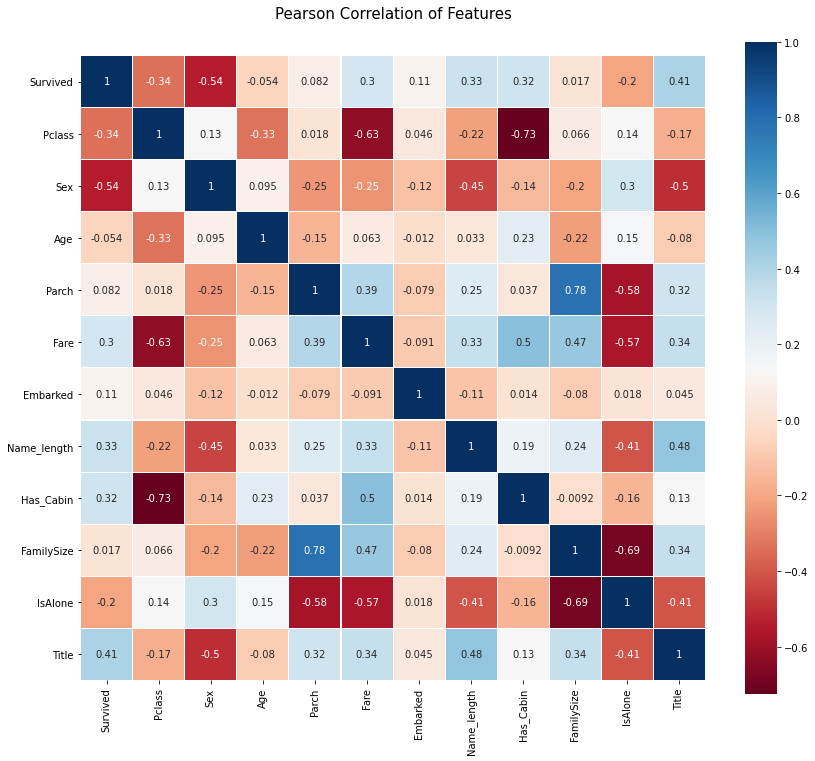

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

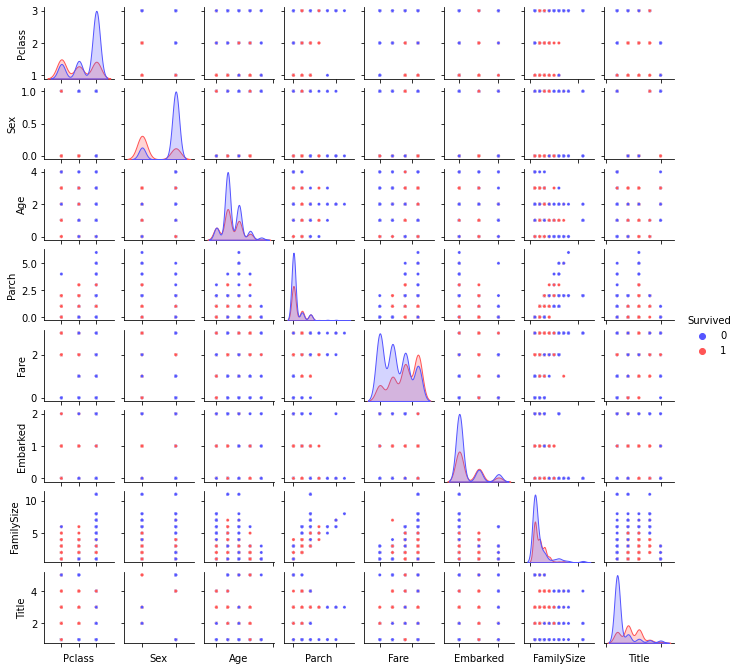

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.
Построение модели
1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

In [6]:
def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, test_size=None, cv=5):
    if test_size is None:
        
        meta_mtrx =  np.empty((data_train.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv = cv, method='predict')    
            model.fit(data_train, targets_train)

        meta_alg.fit(meta_mtrx, targets_train)
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)

        meta_pred = meta_alg.predict(meta_mtrx_test)
        if targets_test.empty == False:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_pred)}')
            print(meta_pred)

    elif test_size > 0 and test_size < 1:
        x_train, x_test, y_train, y_test = train_test_split(data_train, 
                                                      targets_train,
                                                      test_size=test_size,
                                                      random_state=17)

        meta_mtrx = np.empty((x_test.shape[0], len(models)))
        for n, model in enumerate(models):
            model_train = model.fit(x_train, y_train)
            meta_mtrx[:, n] = model_train.predict(x_test)

        meta_model = meta_alg.fit(meta_mtrx, y_test)
        
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))      
        for n, model in enumerate(models):
            #print(data_test.shape)
            meta_mtrx_test[:, n] = model.predict(data_test)
            
        #предсказания мета-алгоритма для значений матрицы meta_mtrx_test
        meta_pred = meta_model.predict(meta_mtrx_test)
        if targets_test.empty == False:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_pred)}')
            print(meta_pred)

    
    else:
        raise ValueError("test_size must be between 0 and 1")

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

In [7]:
train_1 = train.drop(['Survived'], axis =1)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_1, 
                                                    train['Survived'],
                                                    test_size=.3,
                                                    random_state=17)

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [9]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

gbc_clf = GradientBoostingClassifier(random_state=17)
rfc_clf = RandomForestClassifier(random_state=17)
svc = SVC(random_state=17)
lr = LogisticRegression(random_state=17)

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

meta = XGBClassifier(n_estimators=40)
meta_alg = meta

skf = StratifiedKFold(n_splits=5, random_state=17)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

#### 1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

In [10]:
from sklearn.model_selection import GridSearchCV

gsSV_gbs = GridSearchCV(gbc_clf, gbc_params, cv = skf)
gsSV_rfc = GridSearchCV(rfc_clf, rfc_params, cv = skf)
gsSV_svc = GridSearchCV(svc, svc_params, cv = skf)
gsSV_lr = GridSearchCV(lr, lr_params, cv = skf)

#### 2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

In [11]:
gsSV_gbs.fit(x_train, y_train)
gsSV_rfc.fit(x_train, y_train)
gsSV_svc.fit(x_train, y_train)
gsSV_lr.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             estimator=LogisticRegression(random_state=17),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9])})

In [12]:
gsSV_gbs.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, random_state=17)

In [13]:
gsSV_rfc.best_estimator_

RandomForestClassifier(min_samples_leaf=3, n_estimators=30, random_state=17)

In [14]:
gsSV_svc.best_estimator_

SVC(C=0.1, kernel='linear', random_state=17)

In [15]:
gsSV_lr.best_estimator_

LogisticRegression(C=0.7, random_state=17)

#### 3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [16]:
from sklearn.metrics import accuracy_score
#насколько я понял, эта метрика и использутеся для оценки  соревнования

In [17]:
gsSV_gbs.predict(x_test)
print(accuracy_score(y_test, gsSV_gbs.predict(x_test)))

0.7798507462686567


In [18]:
gsSV_rfc.predict(x_test)
print(accuracy_score(y_test, gsSV_rfc.predict(x_test)))

0.7835820895522388


In [19]:
gsSV_svc.predict(x_test)
print(accuracy_score(y_test, gsSV_svc.predict(x_test)))

0.7873134328358209


In [20]:
gsSV_lr.predict(x_test)
print(accuracy_score(y_test, gsSV_lr.predict(x_test)))

0.7947761194029851


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [12]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
meta_alg = XGBClassifier(n_estimators=40, random_state=17)

In [15]:
grid_meta = GridSearchCV(meta_alg, xgb_params, cv=5)

In [29]:
gbc_predictions = gsSV_gbs.predict(x_test)
rfc_predictions = gsSV_rfc.predict(x_test)
svc_predictions = gsSV_svc.predict(x_test)
lr_predictions = gsSV_lr.predict(x_test)
predictions = [gbc_predictions, rfc_predictions, svc_predictions, lr_predictions]

In [31]:
meta_mtrx = np.empty((x_test.shape[0], len(predictions)))

for n, prediction in enumerate(predictions):
    meta_mtrx[:, n] = prediction



In [32]:
xgb_grid = GridSearchCV(XGBClassifier(random_state=17), xgb_params, cv=skf, n_jobs=-1, verbose=True)

xgb_grid.fit(meta_mtrx, y_test)



print(f'Best params of XGBoost: {xgb_grid.best_params_}')

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6960 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 9096 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 12096 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 15496 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 18040 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 20132 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 22432 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 24932 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 27632 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 30532 tas

[20:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params of XGBoost: {'eta': 0.30000000000000004, 'min_child_weight': 2, 'n_estimators': 85, 'subsample': 0.1}


In [33]:
xgb_grid = GridSearchCV(XGBClassifier(random_state=17), xgb_params, cv=5, n_jobs=-1, verbose=True)

xgb_grid.fit(meta_mtrx, y_test)



print(f'Best params of XGBoost: {xgb_grid.best_params_}')

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 4676 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7076 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8576 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 10276 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 12176 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 14276 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 16576 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 19076 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 21728 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 24628 task

[20:42:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params of XGBoost: {'eta': 0.30000000000000004, 'min_child_weight': 2, 'n_estimators': 85, 'subsample': 0.1}


4.

На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [24]:
from sklearn.model_selection import cross_val_predict

In [54]:
def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, test_size=None, cv=5):
    if test_size is None:
        
        meta_mtrx =  np.empty((data_train.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv = cv, method='predict')    
            model.fit(data_train, targets_train)

        meta_alg.fit(meta_mtrx, targets_train)
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)

        meta_pred = meta_alg.predict(meta_mtrx_test)
        #if targets_test.empty == False:
            #print(f'Stacking AUC: {roc_auc_score(targets_test, meta_pred)}')
        print(meta_pred)
        return meta_pred
    elif test_size > 0 and test_size < 1:
        x_train, x_test, y_train, y_test = train_test_split(data_train, 
                                                      targets_train,
                                                      test_size=test_size,
                                                      random_state=17)

        meta_mtrx = np.empty((x_test.shape[0], len(models)))
        for n, model in enumerate(models):
            model_train = model.fit(x_train, y_train)
            meta_mtrx[:, n] = model_train.predict(x_test)

        meta_model = meta_alg.fit(meta_mtrx, y_test)
        
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))      
        for n, model in enumerate(models):
            #print(data_test.shape)
            meta_mtrx_test[:, n] = model.predict(data_test)
            
        #предсказания мета-алгоритма для значений матрицы meta_mtrx_test
        meta_pred = meta_model.predict(meta_mtrx_test)
        if targets_test.empty == False:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_pred)}')
            print(meta_pred)

    
    else:
        raise ValueError("test_size must be between 0 and 1")

In [26]:
gbc_clf = GradientBoostingClassifier(learning_rate=0.2, random_state=17)
#GradientBoostingClassifier(learning_rate=0.2, random_state=17)
rfc_clf = RandomForestClassifier(min_samples_leaf=3, n_estimators=30, random_state=17)
#RandomForestClassifier(min_samples_leaf=3, n_estimators=30, random_state=17)
svc = SVC(C=0.1, kernel='linear', random_state=17)
#SVC(C=0.1, kernel='linear', random_state=17)
lr = LogisticRegression(C=0.7, random_state=17)
#LogisticRegression(C=0.7, random_state=17)

models = [gbc_clf, rfc_clf, svc, lr]

In [27]:
meta_alg = XGBClassifier(eta = 0.30000000000000004, min_child_weight= 2, n_estimators=85, subsample = 0.1,  random_state=17)
#Best params of XGBoost: {'eta': 0.30000000000000004, 'min_child_weight': 2, 'n_estimators': 85, 'subsample': 0.1}

In [28]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
data_train = train.drop(['Survived'], axis = 1)
targets_train = train['Survived']


In [55]:
stacking(models, meta_alg, data_train, targets_train, test, targets_test=None, random_state=None, test_size=None, cv=5)

[22:09:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [48]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


In [52]:
test_load = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test_load['PassengerId']

PassengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [57]:
predictions = stacking(models, meta_alg, data_train, targets_train, test, targets_test=None, random_state=None, test_size=None, cv=5)

[22:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 

In [58]:
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [61]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [62]:
write_to_submission_file(predictions, PassengerId, out_file='Submission.csv', columns=['PassengerID', 'Survived'])

### 6.
Каков результат score, полученного на соревновании?

In [64]:
Score: 0.77272